In [0]:
# !pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


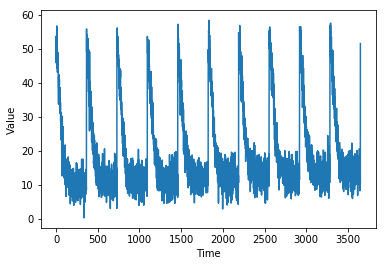

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 3 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
slope = 0.001
# series = trend(time, slope)  
baseline = 10
amplitude = 40
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [4]:
x_train.shape

(3000,)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series) # (n, )
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # (m, windowsize+1)
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # (m, windowsize), # (m, )
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, input_shape=[window_size]),
    tf.keras.layers.LeakyReLU(0.1),
    tf.keras.layers.Dense(20),
    tf.keras.layers.LeakyReLU(0.1), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='nadam')
model.fit(dataset,epochs=100,verbose=0)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                840       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,681
Trainable params: 1,681
Non-trainable params: 0
_________________________________________________________________


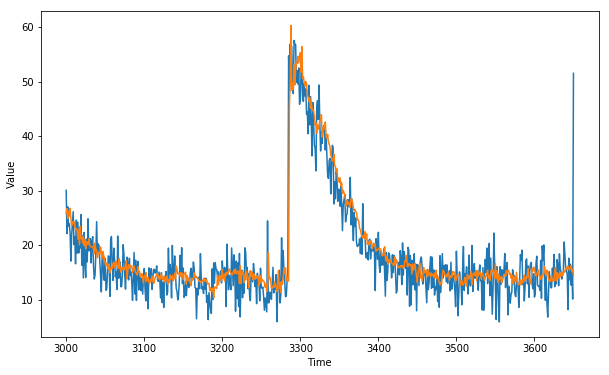

In [7]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis])) # input: (1, window_size)

forecast = forecast[split_time-window_size:] 
results = np.array(forecast)[:, 0, 0]  # results: (m, 1, 1)


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

2.8539693